In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (142).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (63).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (423).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (65).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (329).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (43).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (243).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (50).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (218).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (292).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (135).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (145).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RICE/Class_10/Karacadag (298).jpg
/kaggle/input/rice-model/GAODATASET/ALL_RI

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter


In [20]:
# Đường dẫn dataset
data_dir = "/kaggle/input/rice-model/GAODATASET/ALL_RICE"
image_size = (64, 64)
batch_size = 64


In [21]:
#tải và chuẩn bị dữu liệu
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 5037 files belonging to 10 classes.
Using 4030 files for training.


In [22]:
#tải và chuẩn bị dữ liệu
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 5037 files belonging to 10 classes.
Using 1007 files for validation.


In [23]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [24]:
#in số lớp trước khi huấn luyện
class_names = train_ds.class_names
num_classes = len(class_names)
print("📂 Danh sách lớp:", class_names)
print("📊 Số lớp:", num_classes)


📂 Danh sách lớp: ['Class_01', 'Class_02', 'Class_03', 'Class_04', 'Class_05', 'Class_06', 'Class_07', 'Class_08', 'Class_09', 'Class_10']
📊 Số lớp: 10


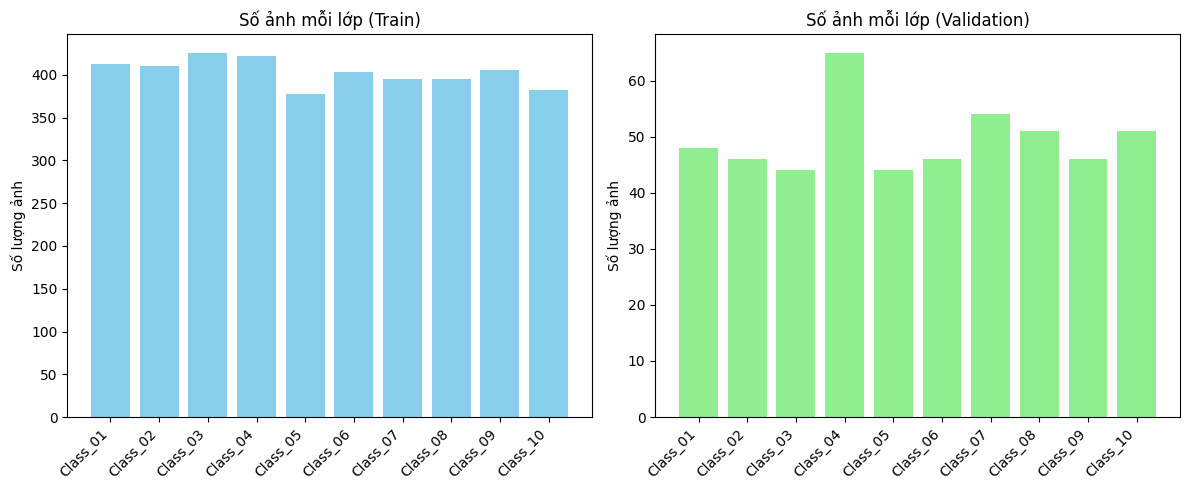

In [25]:
#vẽ biểu đồ 
try:
    def get_label_counts(dataset):
        labels = []
        for _, y in dataset.unbatch():
            labels.append(int(y))
        return Counter(labels)

    train_counts = get_label_counts(train_ds)
    val_counts = get_label_counts(val_ds)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.bar(class_names, [train_counts[i] for i in range(num_classes)], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Số ảnh mỗi lớp (Train)")
    plt.ylabel("Số lượng ảnh")

    plt.subplot(1,2,2)
    plt.bar(class_names, [val_counts[i] for i in range(num_classes)], color='lightgreen')
    plt.xticks(rotation=45, ha='right')
    plt.title("Số ảnh mỗi lớp (Validation)")
    plt.ylabel("Số lượng ảnh")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"LỖI khi vẽ biểu đồ cân bằng lớp: {e}")


In [26]:
#tối ưu dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
#xây dựng mô hình
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
#huấn luyện mô hình
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  
    verbose=1
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2680 - loss: 1.9332 - val_accuracy: 0.5273 - val_loss: 1.2663
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4657 - loss: 1.2993 - val_accuracy: 0.6606 - val_loss: 0.9657
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5941 - loss: 1.0240 - val_accuracy: 0.7394 - val_loss: 0.7755
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6459 - loss: 0.8985 - val_accuracy: 0.7313 - val_loss: 0.7180
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6484 - loss: 0.8422 - val_accuracy: 0.6707 - val_loss: 0.7474
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6984 - loss: 0.7545 - val_accuracy: 0.7374 - val_loss: 0.6265
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7063 - loss: 0.7462 - val_accuracy: 0.7596 - val_loss: 0.6143
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7231 - loss: 0.7119 - val_accuracy: 0.7758 - val_loss

In [29]:
# Đánh giá mô hình trên tập test
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=456,
    image_size=(64, 64),
    batch_size=32
)
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n🔎 Đánh giá trên tập kiểm thử:")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")


Found 5037 files belonging to 10 classes.
Using 1007 files for validation.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8925 - loss: 0.3208

🔎 Đánh giá trên tập kiểm thử:
  - Test Loss: 0.3040
  - Test Accuracy: 0.8898


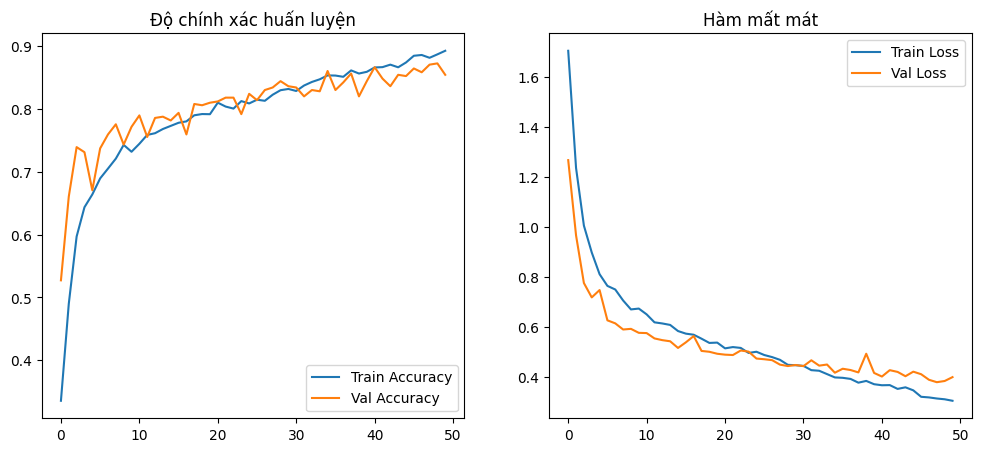

In [30]:
#biểu đồ train/val
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Độ chính xác huấn luyện')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Hàm mất mát')
plt.show()

In [31]:
#kiểm tra huấn luyện
import numpy as np

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    print("True:", labels.numpy()[:10])
    print("Pred:", preds_classes[:10])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
True: [3 2 9 9 7 2 3 7 7 3]
Pred: [3 2 9 9 7 2 3 7 7 3]


In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"🔎 Test accuracy: {test_acc*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8886 - loss: 0.3117
🔎 Test accuracy: 88.98%


In [36]:
#lưu mô hình
model.save("rice_model_fast.h5")
print("✅ Mô hình đã được lưu: rice_model_fast.h5")


✅ Mô hình đã được lưu: rice_model_fast.h5


In [35]:
!ls -lh /kaggle/working


total 14M
-rw-r--r-- 1 root root 14M Oct 21 18:59 rice_model_fast.h5


In [37]:
!zip -r /kaggle/working/rice_project.zip /kaggle/working/rice_model_fast.h5


  adding: kaggle/working/rice_model_fast.h5 (deflated 12%)
